In [1]:
import pandas as pd 
import numpy as np
# !pip install xlsxwriter
import yfinance as yf 
import xlsxwriter
# !pip install openpyxl
import openpyxl
# !pip install mplfinance 
import mplfinance as mpf


In [17]:
class TurtleTrading:
    def __init__(self, ticker, period = "1mo", nse = True, round = 2):
        """['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']"""
        if nse == True:
            stock_exchange = ".NS"
        else:
            stock_exchange = ""    
        self.ticker = ticker  
        self.mod_ticker = ticker + stock_exchange
        self.period = period
        self.round = round

    def fetch_data(self):
        try:
            self.data = yf.download(self.mod_ticker, period = self.period)
        except KeyError:
            print(f"Data for {self.ticker} not available or invalid.")
            
        self.data[['Open','High','Low','Close','Adj Close']] = self.data[['Open','High','Low','Close','Adj Close']].round(self.round)
        return self.data
    
    def calculate_indicators(self):
        if self.data is not None:
            self.data['55d_High'] = self.data['High'].rolling(window=55).max()
            self.data['55d_Low'] = self.data['Low'].rolling(window=55).min()
            self.data['High-Low'] = self.data['High']-self.data['Low']
            self.data['High-PrevClose'] = (self.data['High'] - self.data['Close'].shift(1)).abs()
            self.data['PrevClose-Low'] = (self.data['Close'].shift(1) - self.data['Low']).abs()
            self.data['True_Range'] = self.data[['High-Low', 'High-PrevClose', 'PrevClose-Low']].max(axis = 1)
            self.data['Avg_True_Range(N)'] = self.data['True_Range'].rolling(window = 20).mean().round(2)
            return self.data
        else:
            return ("No data to calculate indicators.")
    
    def generate_signals(self):
        if self.data is not None:
            self.data['Buy_Signal'] = self.data['Close'] > self.data['55d_High'].shift(1)
            self.data['Sell_Signal'] = self.data['Close'] < self.data['55d_Low'].shift(1)
            return self.data
            # buy_sell_signals = self.data[(self.data['Buy_Signal']) | (self.data['Sell_Signal'])]
            # return buy_sell_signals
        else:
            return ("No data to generate signal.") 
           
    def check_buy_signal(self, days = 1):
        if self.data is not None and 'Buy_Signal' in self.data.columns:
            return self.data['Buy_Signal'].tail(days).any()
        else:
            print("No data or Buy_Signal column not found.")
            return False
        
    def save_to_excel(self, filename = "default.xlsx"):
        if self.data is not None:
            self.filename = filename
            
            try:
                # Load the existing workbook, if it exists
                workbook = openpyxl.load_workbook(self.filename)
            except FileNotFoundError:
                # If the file does not exist, create a new workbook
                workbook = openpyxl.Workbook()
                # workbook.remove(workbook.active)
                workbook.save(filename=self.filename)

            with pd.ExcelWriter(filename, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                self.data.to_excel(writer, sheet_name = self.ticker, index = True)

                # Access the workbook and worksheet objects
                workbook  = writer.book
                worksheet = writer.sheets[self.ticker]


                # Define formats for conditional formatting
                # green_fill = workbook.add_format({'bg_color': '#C6EFCE', 'font_color': '#006100'})
                # red_fill = workbook.add_format({'bg_color': '#FFC7CE', 'font_color': '#9C0006'})

                green_fill = openpyxl.styles.PatternFill(start_color='C6EFCE', end_color='C6EFCE', fill_type='solid')
                red_fill = openpyxl.styles.PatternFill(start_color='FFC7CE', end_color='FFC7CE', fill_type='solid')

                # Apply conditional formatting to Buy_Signal and Sell_Signal columns
                buy_signal_col = self.data.columns.get_loc('Buy_Signal') + 1
                sell_signal_col = self.data.columns.get_loc('Sell_Signal') + 1
                # worksheet.conditional_format(1, buy_signal_col, len(self.data), buy_signal_col, 
                #                              {'type': 'cell', 'criteria': '==', 'value': "TRUE", 'format': green_fill})
                # worksheet.conditional_format(1, sell_signal_col, len(self.data), sell_signal_col, 
                #                              {'type': 'cell', 'criteria': '==', 'value': "TRUE", 'format': red_fill})
                
                for row in range(2, len(self.data) + 2):
                    if worksheet.cell(row, buy_signal_col + 1).value:  # Check if Buy_Signal is True
                        for cell in worksheet[row]:
                            cell.fill = green_fill
                    if worksheet.cell(row, sell_signal_col + 1).value:  # Check if Sell_Signal is True
                        for cell in worksheet[row]:
                            cell.fill = red_fill

                
                # Freeze first row and first column
                worksheet.freeze_panes = 'B2'  # Freeze the first row and first column
                
            print(f"{self.ticker} Data saved to {filename}")
        else:
            print("No Data to print")

    def plot_candle_stick(self):
        mpf.plot(self.data, type='candle', volume=False, style='charles', title='Candlestick Chart', ylabel='Price')


[*********************100%%**********************]  1 of 1 completed


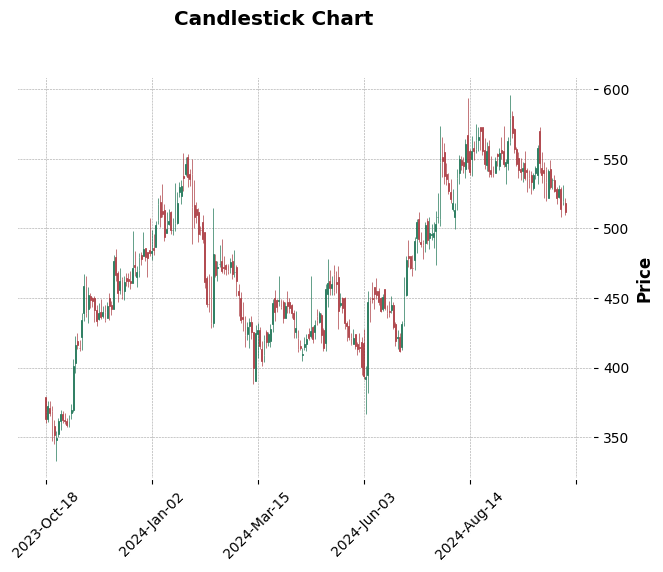

In [3]:
infy = TurtleTrading("JYOTHYLAB", period = "1y")
infy.fetch_data()
infy.calculate_indicators()
infy.generate_signals()
infy.check_buy_signal()
# infy.save_to_excel()
# print(infy_data.tail())
# print(infy_data.info())
infy.plot_candle_stick()

In [18]:
def process_tickers(tickers, days=1, period = "1y", filename="123.xlsx"):
    selective_sticker = []
    for ticker in tickers[50:100]:
        tt = TurtleTrading(ticker, period= period)
        tt.fetch_data()
        tt.calculate_indicators()
        data = tt.generate_signals()
        if tt.check_buy_signal(days):
            tt.save_to_excel(filename)
            selective_sticker.append(ticker)
    print(selective_sticker)

from nifty_50_tickers import nifty_500
process_tickers(nifty_500, days=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


MOTILALOFS Data saved to 123.xlsx


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

['MOTILALOFS']


In [ ]:
# def multi_thread(ticker, days=1, period = "6mo", filename="default5.xlsx"):
#     tt = TurtleTrading(ticker, period= period)
#     tt.fetch_data()
#     tt.calculate_indicators()
#     tt.generate_signals()
#     if tt.check_buy_signal(days):
#         tt.save_to_excel(filename)
#         # selective_sticker.append(ticker)

def multi_thread(ticker, days=1, period="1y", filename="default8.xlsx"):
    tt = TurtleTrading(ticker, period=period)
    try:
        tt.fetch_data()
        tt.calculate_indicators()
        data = tt.generate_signals()
        if tt.check_buy_signal(days):
            tt.save_to_excel(filename)
    except KeyError:
        print(f"Data for {ticker} not available or invalid.")
    except Exception as e:
        print(f"An error occurred with {ticker}: {e}")
import threading
import time

threads = []
i = 1
for ticker in nifty_500[:100]:
    thread_name = "thread" + str(i)
    i += 1
    # print(thread_name)
    thread = threading.Thread(target=multi_thread, args= (ticker,), name= thread_name)
    threads.append(thread)
    time.sleep(0.01)
    thread.start()
    if i % 2 == 0:
        thread.join()   
# thread.join()
# print("pass")

# for thread in threads:
#     thread.join()
print("done")
# An error occurred with JYOTHYLAB: 'TurtleTrading' object has no attribute 'data'


In [6]:
sel_stick = ['JAIBALAJI', 'SBILIFE', 'QUESS', 'ICICIGI', 'BBTC', 'ERIS', 'HDFCLIFE', 'ICICIPRULI', 'JMFINANCIL', 'PNBHOUSING', 'JINDALSAW', 'OFSS', 'BAJAJFINSV', 'GODREJIND', 'BAJAJHLDNG', 'MANYAVAR', 'POLYMED', 'SBICARD', 'HFCL', 'JKCEMENT', 'SHRIRAMFIN', 'CHOLAFIN', 'KALYANKJIL', 'PERSISTENT', 'M&MFIN']


In [7]:
for stk in sel_stick[:10]:
    tt = TurtleTrading(stk, period = "1y")
    tt.fetch_data()
    tt.calculate_indicators()
    tt.generate_signals()
    tt.check_buy_signal()
    tt.plot_candle_stick()
    

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


Data for SOBHA not available or invalid.
An error occurred with SOBHA: 'TurtleTrading' object has no attribute 'data'


Data for JAIBALAJI not available or invalid.


AttributeError: 'TurtleTrading' object has no attribute 'data'